In [17]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [18]:

bag = rosbag.Bag('/home/uware/rosbags/25h9_slz_2-4-6-8-10_360_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6]

In [19]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [20]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,1.908570
1,0.063482,1.927094
2,0.776844,2.008212
3,0.840539,1.999719
4,0.907908,1.984563
...,...,...
1247,126.346909,1.603789
1248,126.380880,1.573041
1249,126.413937,1.535043
1250,126.447239,1.490486


<AxesSubplot:xlabel='relative_time'>

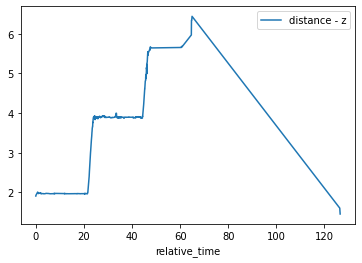

In [21]:
# initial graph
df.plot(x='relative_time', y=target)

In [22]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [23]:
# the amount of data points we are left with
len(x[peaks])

245

In [24]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

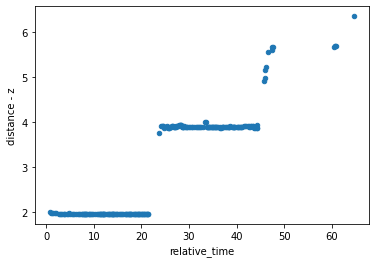

In [25]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [26]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
len(df_filtered_by_targets)

245

In [27]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [28]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [29]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
2,0.776844,2.008212,2,-0.008212
6,1.038972,1.980636,2,0.019364
579,23.683247,3.765623,4,0.234377
585,24.115516,3.913355,4,0.086645
1198,45.686358,4.912327,6,1.087673
1203,45.883427,4.978627,6,1.021373


In [30]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,110.0,0.028930,0.005381,-0.008212,0.027174,0.030445,0.032011,0.035209
4,122.0,0.100684,0.021783,0.002069,0.096158,0.101553,0.105245,0.234377
6,13.0,0.476063,0.378139,-0.345334,0.322262,0.336205,0.770572,1.087673


In [31]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

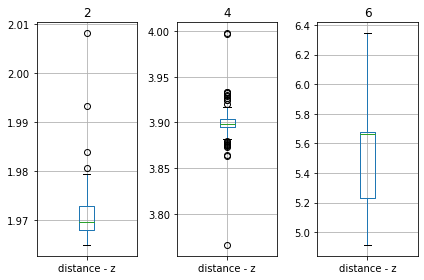

In [32]:
box_plotter(target)

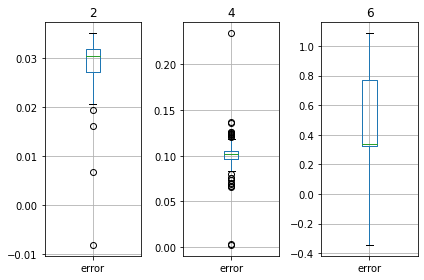

In [33]:
box_plotter('error')